In [1]:
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Flatten 
import tensorflow as tf

# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Point

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2023-04-17 18:49:34.137525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 18:49:34.192357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 18:49:34.193113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 18:49:35.304593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# https://dontrepeatyourself.org/post/save-and-load-models-with-tensorflow/


model = tf.keras.models.load_model("w_model", compile = True)

2023-04-17 18:49:37.112694: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-17 18:49:37.391950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-04-17 18:49:37.392129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMEN

2023-04-17 18:49:38.015366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-04-17 18:49:38.015502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_1_grad_concat_split_1_split_dim' with dtype int32
	 [[{{node gradients_split_1_grad_concat_split_1_split_dim}}]]
2023-04-17 18:49:38.189695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-17 18:49:39.239296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-04-17 18:49:39.239476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-04-17 18:49:39.239602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [3]:

# Create Point for San Diego: 32.7338° N, 117.1933° W
sd = Point(32.7338, 117.1933)

In [4]:
# script to get data of requested city in recent days


# data units
# ① Humidity (%), ② Pressure (hPa), ③ Temperature (K), 4) Wind Speed (m/s).

# sd coordinates: 32.7157° N, 117.1611° W


# Set time period
start = datetime(2023, 4, 1)
end = datetime(2023, 4, 16, 23, 59)

# Get hourly data
data = Hourly(sd, start, end)
data = data.fetch()

# Print DataFrame
actualData = data[['temp','pres','rhum','wspd']]


def f(x):
    x = x + 273.15
    return float(x)


actualData['temp'] = actualData['temp'].map(lambda a: a+273.15)
actualData

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,temp,pres,rhum,wspd
time,,,,
2023-04-01 00:00:00,285.75,1015.8,85.0,9.3
2023-04-01 01:00:00,287.65,1015.7,77.0,9.3
2023-04-01 02:00:00,289.55,1015.6,70.0,9.3
2023-04-01 03:00:00,291.55,1015.5,63.0,11.1
2023-04-01 04:00:00,293.35,1014.6,55.0,9.3
...,...,...,...,...
2023-04-16 19:00:00,289.75,1005.5,68.0,13.0
2023-04-16 20:00:00,289.45,1005.5,70.0,13.0
2023-04-16 21:00:00,289.05,1005.5,74.0,13.0


In [5]:
features = actualData

training_size = int (0.8*features.shape[0])  

dataset=features.values
data_mean = dataset[:training_size].mean(axis=0)
data_std = dataset[:training_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset.shape

dataset=dataset.astype(float)

In [6]:
past_history = 48
future_target = 24
STEP = 1

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [8]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 training_size, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             training_size, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(259, 48, 4)
(259, 24)


In [9]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (48, 4)

 Target temperature to predict : (24,)


In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [11]:
predictionsPrint = np.array(0);

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    
    predictionsPrint = np.arange(num_out)/STEP
    print(np.array(prediction))
  plt.legend(loc='upper left')
  plt.show()

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

2023-04-17 18:49:40.649194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5,24]
	 [[{{node Placeholder/_1}}]]
2023-04-17 18:49:40.990724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-17 18:49:40.992516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'g

1/1 [==============================] - 1s 796ms/step
[-1.3671993 -1.2263334 -1.2750664 -1.2324804 -1.1909121 -1.2037238
 -1.0651941 -1.1505561 -1.0368215 -1.0512446 -1.1188534 -1.0780885
 -1.1121608 -1.2206368 -1.1117784 -1.1976098 -1.042277  -1.1364219
 -1.2949003 -1.0833231 -1.1140002 -1.2563709 -1.0962825 -1.1100351]


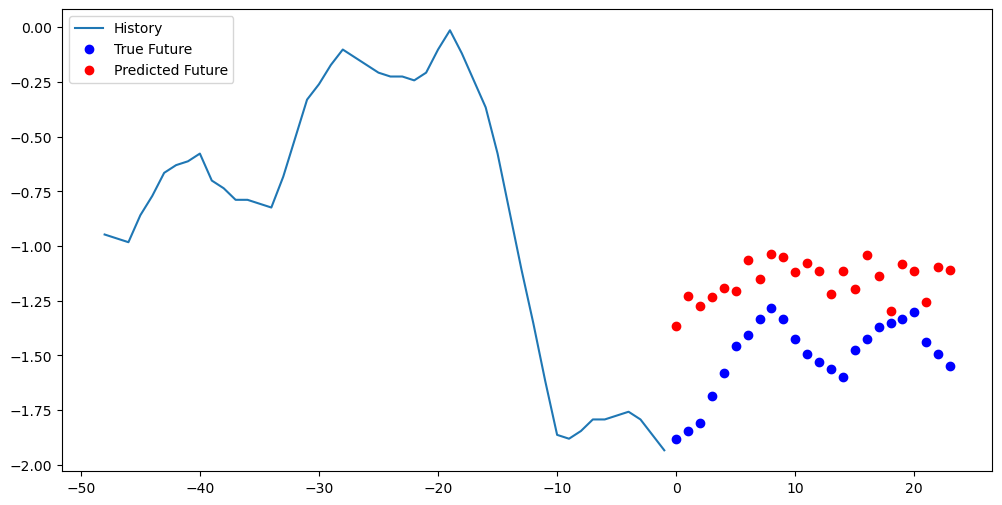

In [13]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], model.predict(x)[0])

# print(model.predict(x_train_multi))



In [14]:
# print(model.predict(x))


In [15]:

def plot_test(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    
  plt.legend(loc='upper left')
  plt.show()

1/1 [==============================] - 0s 27ms/step


2023-04-17 18:49:41.745477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5,24]
	 [[{{node Placeholder/_1}}]]


[-1.3671993 -1.2263334 -1.2750664 -1.2324804 -1.1909121 -1.2037238
 -1.0651941 -1.1505561 -1.0368215 -1.0512446 -1.1188534 -1.0780885
 -1.1121608 -1.2206368 -1.1117784 -1.1976098 -1.042277  -1.1364219
 -1.2949003 -1.0833231 -1.1140002 -1.2563709 -1.0962825 -1.1100351]


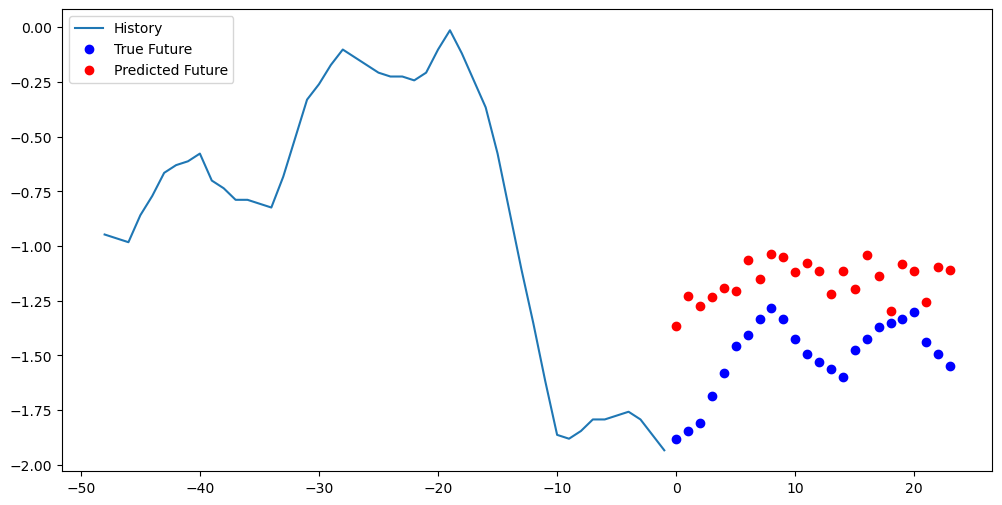

In [16]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], model.predict(x)[0])


In [17]:
def denormalize(a):
    #     data_mean = dataset[:training_size].mean(axis=0)
    #     data_std = dataset[:training_size].std(axis=0)
    #     dataset = (dataset-data_mean)/data_std
    return a*data_std[0]+data_mean[0]-273.15

denorm = np.vectorize(denormalize)
predictAns = np.array(model.predict(x)[0])
print(denorm(predictAns))

# data_mean[]

1/1 [==============================] - 0s 26ms/step
[ 9.02267524  9.68404258  9.45524053  9.65518221  9.85034582  9.79019491
 10.44059346 10.03981796 10.5738034  10.50608661 10.18866225 10.38005412
 10.22008432  9.71078789 10.22187981  9.81890024 10.54818979 10.10617806
  9.36212    10.35547761 10.21144832  9.54301602 10.29463324 10.2300647 ]
